In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

In [8]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset


from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
df = pd.read_csv('/content/drive/MyDrive/SOFT_COMP_LAB/Dataset.csv')
df.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [43]:
df = df.sample(frac = 1)

from sklearn.model_selection import train_test_split
text = df['Text'].values
label = df['Sentiment'].values
text_train, text_test, label_train, label_test = train_test_split(text, label, test_size=0.20, random_state=20)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5791 entries, 5542 to 2563
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Text            5791 non-null   object
 1   Sentiment       5791 non-null   int64 
 2   processed_text  5791 non-null   object
dtypes: int64(1), object(2)
memory usage: 181.0+ KB


# One hot embedding + CNN

In [45]:
 from keras.preprocessing.text import Tokenizer
 tokenizer = Tokenizer()
 tokenizer.fit_on_texts(text_train)
 Xcnn_train = tokenizer.texts_to_sequences(text_train)
 Xcnn_test = tokenizer.texts_to_sequences(text_test)
 vocab_size = len(tokenizer.word_index)+1
 print(text_train[1])
 print(Xcnn_train[1]) 

AMZN nice intraday flag
[123, 55, 469, 199]


In [46]:
 from keras.preprocessing.sequence import pad_sequences
 maxlen = 150
 Xcnn_train = pad_sequences(Xcnn_train, padding='post', maxlen=maxlen)
 Xcnn_test = pad_sequences(Xcnn_test, padding='post', maxlen=maxlen)
 print(Xcnn_train[0, :]) 

[  7 701   2  41 306 597  21  19 106 171   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]


In [47]:
from keras.models import Sequential
from keras import layers 
import tensorflow as tf

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 200)          1792000   
                                                                 
 conv1d_6 (Conv1D)           (None, 149, 256)          102656    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 74, 256)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 72, 128)           98432     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 36, 128)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 33, 32)           

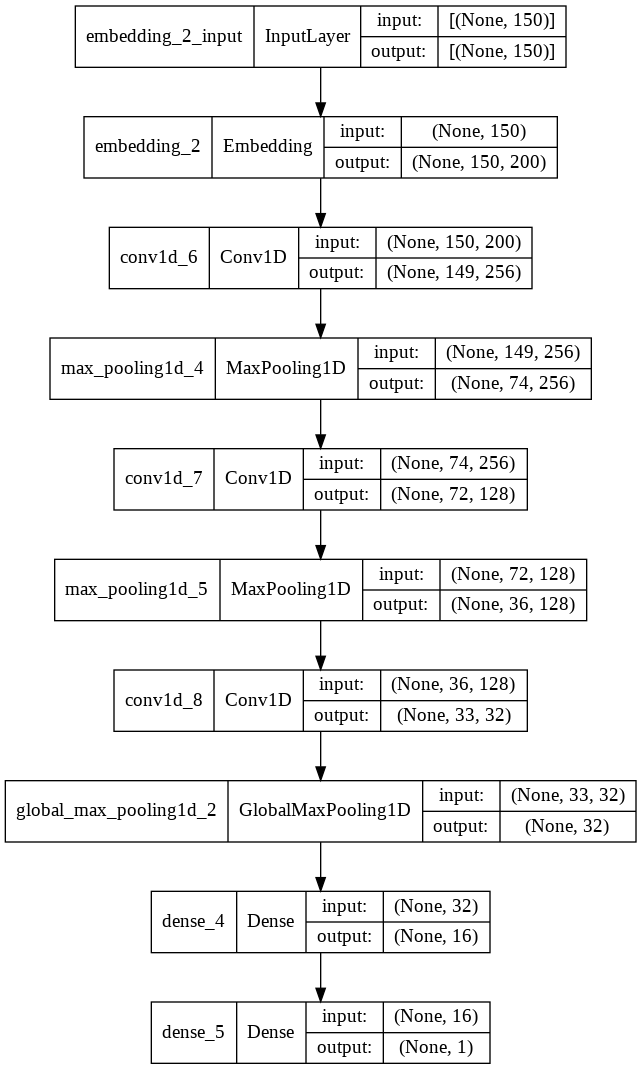

In [50]:
seed = 170204036
torch.manual_seed(seed)
embedding_dim = 200
textcnnmodel = Sequential()
textcnnmodel.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
textcnnmodel.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
textcnnmodel.add(layers.MaxPooling1D(pool_size = 2))
textcnnmodel.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
textcnnmodel.add(layers.MaxPooling1D(pool_size = 2))
textcnnmodel.add(layers.Conv1D(filters=32, kernel_size=4, activation='relu'))
textcnnmodel.add(layers.GlobalMaxPooling1D())
textcnnmodel.add(layers.Dense(16, activation='relu'))
textcnnmodel.add(layers.Dense(1, activation='sigmoid'))
textcnnmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

textcnnmodel.summary() 

tf.keras.utils.plot_model(textcnnmodel, show_shapes = True, show_layer_names = True)


In [15]:
history = textcnnmodel.fit(Xcnn_train, label_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(Xcnn_test, label_test),
                    batch_size=10)
loss, accuracy = textcnnmodel.evaluate(Xcnn_train, label_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = textcnnmodel.evaluate(Xcnn_test, label_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/50
464/464 [==============================] - 9s 20ms/step - loss: -4227765633024.0000 - accuracy: 0.3266 - val_loss: -3917801324544.0000 - val_accuracy: 0.2468
Epoch 2/50
464/464 [==============================] - 6s 14ms/step - loss: -6681130958848.0000 - accuracy: 0.3264 - val_loss: -5975652171776.0000 - val_accuracy: 0.2399
Epoch 3/50
464/464 [==============================] - 6s 13ms/step - loss: -10127310585856.0000 - accuracy: 0.3264 - val_loss: -8835041329152.0000 - val_accuracy: 0.2416
Epoch 4/50
464/464 [==============================] - 6s 13ms/step - loss: -14838045605888.0000 - accuracy: 0.3228 - val_loss: -12702134042624.0000 - val_accuracy: 0.2528
Epoch 5/50
464/464 [==============================] - 6s 13ms/step - loss: -21057842970624.0000 - accuracy: 0.3335 - val_loss: -17669057150976.0000 - val_accuracy: 0.2312
Epoch 6/50
464/464 [==============================] - 6s 13ms/step - loss: -29159269072896.0000 - accuracy: 0.3174 - val_loss: -24229107990528.0000 - 

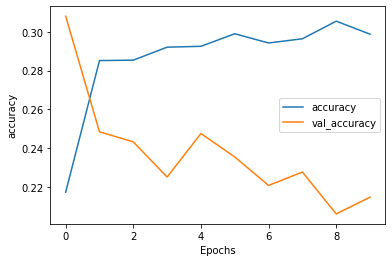

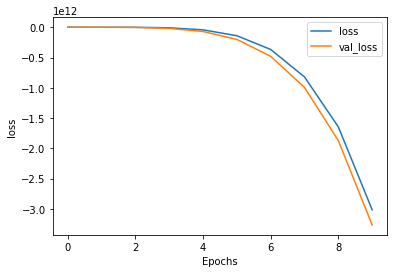

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [52]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

y_pred = textcnnmodel.predict(Xcnn_train)

y_pred = np.where(y_pred > 0, 1, -1)
y_pred = np.reshape(y_pred, (y_pred.shape[0]))

loss, accuracy = textcnnmodel.evaluate(Xcnn_train, label_train, verbose = 1)

145/145 [==============================] - 6s 36ms/step - loss: 0.6947 - accuracy: 0.3670


In [17]:
print('Train Loss:', loss)
print('Train Accuracy:', accuracy, '(Model Metric)')
print('Train Accuracy:', accuracy_score(label_train, y_pred), '(sklearn Metric)')
print('Train Precision:', precision_score(label_train, y_pred))
print('Train Recall:', recall_score(label_train, y_pred))
print('Train F1-score:', f1_score(label_train, y_pred))

Train Loss: -2.507576712573747e+16
Train Accuracy: 0.34088945388793945 (Model Metric)
Train Accuracy: 0.6925734024179621 (sklearn Metric)
Train Precision: 0.9831880448318805
Train Recall: 0.5305779569892473
Train F1-score: 0.6892186817983413


In [51]:
sns.heatmap(confusion_matrix(label_train, y_pred), annot = True, fmt = 'b', cmap='Greens_r')

NameError: ignored

In [19]:
y_pred = textcnnmodel.predict(Xcnn_test)

y_pred = np.where(y_pred > 0, 1, -1)
y_pred = np.reshape(y_pred, (y_pred.shape[0]))

Test Accuracy: 0.5884383088869716 (sklearn Metric)


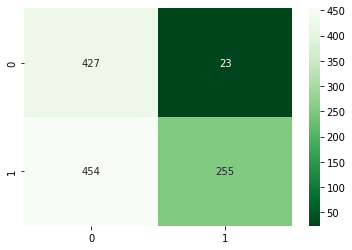

In [20]:
print('Test Accuracy:', accuracy_score(label_test, y_pred), '(sklearn Metric)')
sns.heatmap(confusion_matrix(label_test, y_pred), annot = True, fmt = 'g', cmap='Greens_r')

# BOW + NN

In [3]:
# get a word count per of text
def word_count(words):
    return len(words.split())

In [4]:
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, WordNetLemmatizer
import nltk
import re 
import string
import pickle
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))
print(stop_words)

{'how', 'into', "shouldn't", 'did', 'themselves', "didn't", 'doesn', 'it', 'the', 'didn', 'herself', 'out', 'ma', 'other', 'because', "shan't", 'not', 'being', 'does', 'for', "doesn't", "couldn't", 'whom', 'up', "wasn't", 'won', "she's", 'these', 'yourselves', 'now', 'should', 'same', 'been', 'than', 'again', 'me', 'but', 'a', 'most', 'will', 'off', 'so', 'through', 've', 'o', 'y', 'few', "mustn't", 'in', 'hers', 'at', 'was', 'only', "weren't", 'your', 'this', 'such', 'until', 'don', 'there', 'itself', 'are', 'can', 'she', 'where', "haven't", 'what', "hadn't", 'wasn', 'very', 'those', 'll', 'am', 'too', 'if', 'their', "wouldn't", "hasn't", 'needn', 'm', "you're", 'mightn', 'both', 'after', 's', 'has', 'mustn', 'had', 'our', 'theirs', "you'll", 'ourselves', 'i', "should've", 'shouldn', 'just', 'above', 'under', 'were', 'or', "don't", 'he', 'him', 'is', 'doing', 'who', 'have', "mightn't", 'during', 'haven', 'her', 'with', 'further', 't', 'd', 'we', "you've", 'ain', 'shan', "it's", 'from'

In [9]:
seed = 170204036
torch.manual_seed(seed)

In [15]:
df["Sentiment"] = df["Sentiment"].replace(-1,0)
df["Sentiment"].value_counts()

1    3685
0    2106
Name: Sentiment, dtype: int64

In [16]:
#Checking if any null values present
(df.isnull().sum() / len(df))*100

Text         0.0
Sentiment    0.0
dtype: float64

In [17]:
ps = PorterStemmer()
lemma = WordNetLemmatizer()
stopwordSet = set(stopwords.words("english"))

In [18]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
def process_text(text):
  # Lower Casing
    text = text.lower()
    text=text[1:]
    # Removing all URls 
    text = re.sub(urlPattern,'',text)
    # Removing all @username.
    text = re.sub(userPattern,'',text) 
    #Remove punctuations
    text = text.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(text)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopwordSet]
    #reducing a word to its word stem 
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = ps.stem(w)
        finalwords.append(word)
    return ' '.join(finalwords)   

In [19]:
df['processed_text'] = df['Text'].apply(lambda x: process_text(x))
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [20]:
print(df.shape)
df

(5791, 3)


,Text,Sentiment,processed_text
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,icker watchlist xide tit soq pnk cpw bpz aj tr...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,ser aap movi 55 return feage indic 15 trade ye...
2,user I'd be afraid to short AMZN - they are lo...,1,ser id afraid short amzn look like nearmonopol...
3,MNTA Over 12.00,1,nta 1200
4,OI Over 21.37,1,2137
...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,ndustri bodi cii said discom like suffer net r...
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,gold price slip rs 46000 investor book profit ...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,orker bajaj auto agre 10 wage cut period april...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,sharemarket live sensex day high 600 point nif...


In [21]:
cv = CountVectorizer(max_features = len(df))
X = cv.fit_transform(df['processed_text']).toarray()
y= df['Sentiment'].to_numpy()

#X = torch.from_numpy(X).type(torch.LongTensor)
#y = torch.from_numpy(y).type(torch.LongTensor)

X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [22]:
## Split the dataset into Training and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state = seed)

X_train = X_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 512) 
        self.layer_2 = nn.Linear(512, 128) 
        self.layer_3 = nn.Linear(128, 1)   
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout()
        # self.flatten = nn.Flatten()

        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_3(x)
        logits = self.sigmoid(x)
        return logits

In [24]:
model = NeuralNetwork(len(df))
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=5791, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [25]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

loss_fn = nn.BCEWithLogitsLoss()
model = model.to(device)

loss_fn = loss_fn.to(device)

In [26]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [31]:
def trainModel(model, loss_fn, optimizer):
    model.train()

    batch = 256
    size = X_test.shape[0]

    loss = 0
    acc = 0
    

    for i in range(X_train.shape[0]):
      x, y = X_train[i], torch.tensor([y_train[i]], dtype=torch.float)
    
      # Compute prediction 
      pred = model(x)
      loss += loss_fn(pred,y)
      acc += binary_accuracy(pred,y)
      
      if i>0 and (i+1)%batch == 0:
          # Backpropagation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
         # print(f'Training Loss: {loss.item():.4f}', end="\r")
         # print(f'\tTraining Loss: {loss.item():.3f} | Training Acc: {acc.item()*100:.2f}%')
          loss = 0
          acc = 0
    print()
    return loss.item()/size, acc.item()/size

In [32]:
from numpy.lib.function_base import append

TP=[]
TN=[]
FP=[]
FN=[]
def testModel(model, loss_fn):
    model.eval()
    size = X_test.shape[0]
    loss = 0
    acc = 0
    with torch.no_grad():
      for i in range(X_test.shape[0]):
        x, y = X_test[i], torch.tensor([y_test[i]], dtype=torch.float)
    
        # Compute prediction error
        pred = model(x)
        if( (torch.round(pred)) == 1 and y== 0) :
           FP.append(1)
        if( (torch.round(pred)) == 0 and y== 1) :
           FN.append(1)
        if( (torch.round(pred)) == 1 and y== 1) :
           TP.append(1)
        if( (torch.round(pred)) == 0 and y== 0) :
           TN.append(1)         
       
            
        loss += loss_fn(pred, y).item()
        acc += binary_accuracy(pred,y).item()
      
    loss /= size
    acc /= size
    
    #print(f'Testing Loss: {loss}')
    #print(f'\t Val. Loss: {loss:.3f} |  Val. Acc: {acc*100:.2f}%')
  
    return loss, acc  

In [53]:
epochs = 1
best_valid_loss = float('inf')

# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):

    train_loss,train_acc = trainModel(model, loss_fn, optimizer)
    valid_loss, valid_acc = testModel(model, loss_fn)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'stock_sentiment.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    epoch_tr_loss.append(train_loss)
    epoch_vl_loss.append(valid_loss)
    epoch_tr_acc.append(train_acc)
    epoch_vl_acc.append(valid_acc)

AttributeError: ignored

In [34]:
TP=len(TP)
TN=len(TN)
FP=len(FP)
FN=len(FN)

In [35]:
acc=(TP+TN)/(TP+TN+FN+FP)
acc

0.7713546160483176

In [36]:
prec=TP/(TP+FP)
prec

0.8092783505154639

In [37]:
rec=TP/(TP+FN)
rec

0.8429530201342282

In [38]:
f1score=2*prec*rec/(prec+rec)
f1score

0.8257725180802103

# TF-IDF + NN

In [39]:
tfidf = TfidfVectorizer( ngram_range=(1,3), analyzer='char')
X = cv.fit_transform(df['processed_text']).toarray()
y= df['Sentiment'].to_numpy()

X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [40]:
## Split the dataset into Training and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state = seed)

X_train = X_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 512) 
        self.layer_2 = nn.Linear(512, 128) 
        self.layer_3 = nn.Linear(128, 1)   
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout()
        # self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_3(x)
        logits = self.sigmoid(x)
        return logits

In [ ]:
model = NeuralNetwork(len(df))
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=5791, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

loss_fn = nn.BCEWithLogitsLoss()
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
def binary_accuracy(preds, y):

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def trainModel(model, loss_fn, optimizer):
    model.train()

    batch = 256
    size = X_test.shape[0]

    loss = 0
    acc = 0
    

    for i in range(X_train.shape[0]):
      x, y = X_train[i], torch.tensor([y_train[i]], dtype=torch.float)
    
      # Compute prediction 
      pred = model(x)
      loss += loss_fn(pred,y)
      acc += binary_accuracy(pred,y)
      
      if i>0 and (i+1)%batch == 0:
          # Backpropagation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
         # print(f'Training Loss: {loss.item():.4f}', end="\r")
         # print(f'\tTraining Loss: {loss.item():.3f} | Training Acc: {acc.item()*100:.2f}%')
          loss = 0
          acc = 0
    print()
    return loss.item()/size, acc.item()/size

In [ ]:
from numpy.lib.function_base import append

TP=[]
TN=[]
FP=[]
FN=[]
def testModel(model, loss_fn):
    model.eval()
    size = X_test.shape[0]
    loss = 0
    acc = 0
    
    with torch.no_grad():
      for i in range(X_test.shape[0]):
        x, y = X_test[i], torch.tensor([y_test[i]], dtype=torch.float)
    
        # Compute prediction error
        pred = model(x)
        if( (torch.round(pred)) == 1 and y== 0) :
           FP.append(1)
        if( (torch.round(pred)) == 0 and y== 1) :
           FN.append(1)
        if( (torch.round(pred)) == 1 and y== 1) :
           TP.append(1)
        if( (torch.round(pred)) == 0 and y== 0) :
           TN.append(1)         
       
            
        loss += loss_fn(pred, y).item()
        acc += binary_accuracy(pred,y).item()
      
    loss /= size
    acc /= size
    
    #print(f'Testing Loss: {loss}')
    #print(f'\t Val. Loss: {loss:.3f} |  Val. Acc: {acc*100:.2f}%')
  
    return loss, acc

In [ ]:
epochs = 1
best_valid_loss = float('inf')

# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):

    train_loss,train_acc = trainModel(model, loss_fn, optimizer)
    valid_loss, valid_acc = testModel(model, loss_fn)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'stock_sentiment.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    epoch_tr_loss.append(train_loss)
    epoch_vl_loss.append(valid_loss)
    epoch_tr_acc.append(train_acc)
    epoch_vl_acc.append(valid_acc)


	Train Loss: 0.013 | Train Acc: 1.38%
	 Val. Loss: 0.650 |  Val. Acc: 63.24%


In [ ]:
TP=len(TP)
TN=len(TN)
FP=len(FP)
FN=len(FN)

In [ ]:
acc=(TP+TN)/(TP+TN+FN+FP)
acc

0.6911130284728214

In [ ]:
prec=TP/(TP+FP)
prec

0.6757263355201499

In [ ]:
rec=TP/(TP+FN)
rec

0.9836289222373806

In [ ]:
f1score=2*prec*rec/(prec+rec)
f1score

0.8011111111111112